# XBRL Reader para fondos españoles

El objetivo de este notebook es desarrollar un parser de documentos XBRL remitidos a la CNMV por fondos de inversión en España.

## Table of contents

* Libraries import 
* XBRL document import

## Libraries import

In [167]:
%matplotlib inline
import pandas as pd
import numpy as np
import lxml
from lxml import etree
import datetime as dt
import matplotlib.pyplot as plt

## XBRL document import

Comment and uncomment accordingly

In [152]:
tree = etree.parse('./data/az_valor_iberia_H1_17.XML')
tree = etree.parse('./data/bestinver_iberia_H1_17.XML')
tree = etree.parse('./data/cobas_iberia_H1_17.XML')

root = tree.getroot()
gestora = 'AZ VALOR'
fondo = 'AZ VALOR IBERIA'

gestora = 'BESTINVER'
fondo = 'BESTINVER BOLSA'

gestora = 'COBAS'
fondo = 'COBAS IBERIA'

In [153]:
KEY_CTX = "{http://www.xbrl.org/2003/instance}"

In [154]:
context = root.find("" + KEY_CTX + "context")

## Get dates

In [155]:
start_date_str = context.getchildren()[1].getchildren()[0].text
end_date_str = context.getchildren()[1].getchildren()[1].text
start_date = dt.datetime.strptime(start_date_str, "%Y-%m-%d")
end_date = dt.datetime.strptime(end_date_str, "%Y-%m-%d")

In [156]:
STOCK_KEY = "{http://www.cnmv.es/iic/com/1-2009/2009-03-31}"

stocks = root.findall(".//" + STOCK_KEY + "InversionesFinancierasRVCotizada")

pandas_list = []

for stock in stocks:
    dict_aux = {}
    
    # Meta information
    dict_aux['CodigoISIN'] = stock.find(STOCK_KEY + "CodigoISIN").text
    dict_aux['Name'] = stock.find(STOCK_KEY + "InversionesFinancierasDescripcion").text.split("|")[1]

        
    importes = stock.findall(STOCK_KEY + "InversionesFinancierasImporte")
    t_key = importes[0].find(STOCK_KEY + "InversionesFinancierasValor").get('contextRef')
    if t_key.endswith('ia'):
        current = importes[0]
        try:
            before = importes[1]
        except:
            before = None   
    else:
        before = importes[0]
        try:
            current = importes[1]
        except:
            current = None
    
    # Importes
    try:
        dict_aux['Importe_0'] = float(before.find(STOCK_KEY + "InversionesFinancierasValor").text)
        dict_aux['Percent_0'] = float(before.find(STOCK_KEY + "InversionesFinancierasPorcentaje").text)
    except:
        dict_aux['Importe_0'] = 0.0
        dict_aux['Percent_0'] = 0.0
        
    try:
        dict_aux['Importe_1'] = float(current.find(STOCK_KEY + "InversionesFinancierasValor").text)
        dict_aux['Percent_1'] = float(current.find(STOCK_KEY + "InversionesFinancierasPorcentaje").text)
    except:
        dict_aux['Importe_1'] = 0.0
        dict_aux['Percent_1'] = 0.0
    
    # Additional information
    dict_aux['start_date'] = start_date
    dict_aux['end_date'] = end_date
    dict_aux['fondo'] = fondo
    dict_aux['gestora'] =  gestora
    
    pandas_list.append(dict_aux)

In [157]:
df3 = pd.DataFrame(pandas_list)

In [158]:
df = pd.concat([df1, df2, df3])

In [159]:
df.sort_values('Percent_1')

,CodigoISIN,Importe_0,Importe_1,Name,Percent_0,Percent_1,end_date,fondo,gestora,start_date
0,ES0117160111,782527.0,5290.0,CORP FINAN ALBA,0.70,0.00,2017-06-30,AZ VALOR IBERIA,AZ VALOR,2017-01-01
27,PTALT0AE0002,1435318.0,404.0,ALTRI SGPS,1.29,0.00,2017-06-30,AZ VALOR IBERIA,AZ VALOR,2017-01-01
18,ES0139140174,1943124.0,763.0,INMOBILIARIA COLONIAL SA,1.74,0.00,2017-06-30,AZ VALOR IBERIA,AZ VALOR,2017-01-01
31,PTCTT0AM0001,1291256.0,554.0,CTT-CORREIOS DE PORTUGAL SA,1.16,0.00,2017-06-30,AZ VALOR IBERIA,AZ VALOR,2017-01-01
16,ES0105026001,2024616.0,1496.0,AXIARE PATRIMONIO SOCIMI SA,1.82,0.00,2017-06-30,AZ VALOR IBERIA,AZ VALOR,2017-01-01
15,ES0105022000,844008.0,1102.0,APPLUS,0.76,0.00,2017-06-30,AZ VALOR IBERIA,AZ VALOR,2017-01-01
14,ES0105019006,1494488.0,1448.0,HISPANIA ACTIVOS INMOBILIARIOS,1.34,0.00,2017-06-30,AZ VALOR IBERIA,AZ VALOR,2017-01-01
6,ES0673516995,125032.0,0.0,REPSOL YPF,0.04,0.00,2017-06-30,BESTINVER BOLSA,BESTINVER,2017-01-01
10,ES0124244E34,3849570.0,0.0,MAPFRE,1.33,0.00,2017-06-30,BESTINVER BOLSA,BESTINVER,2017-01-01
20,ES0111845014,842624.0,0.0,ABERTIS INFRAESTRUCTURAS SA,0.76,0.00,2017-06-30,AZ VALOR IBERIA,AZ VALOR,2017-01-01


In [196]:
def plot_fund_dist(fund_name):
    fig = plt.figure(figsize=(15,10))
    select = df[df['fondo']==fund_name][['Percent_1', 'Name']].sort_values('Percent_1')
    ind = np.arange(select.shape[0])
    
    p1 = plt.bar(ind, select['Percent_1'])

    plt.ylabel('PCT in fund', fontsize=14)
    plt.xticks(ind, select['Name'], rotation=90, fontsize=12)
    plt.title(fund_name, fontsize=14)
    plt.grid()


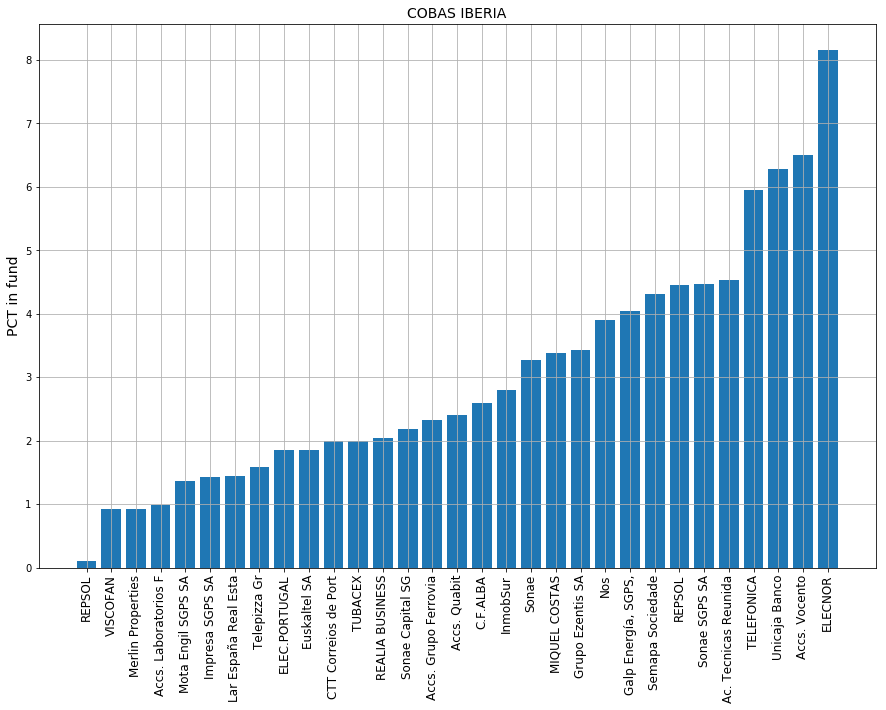

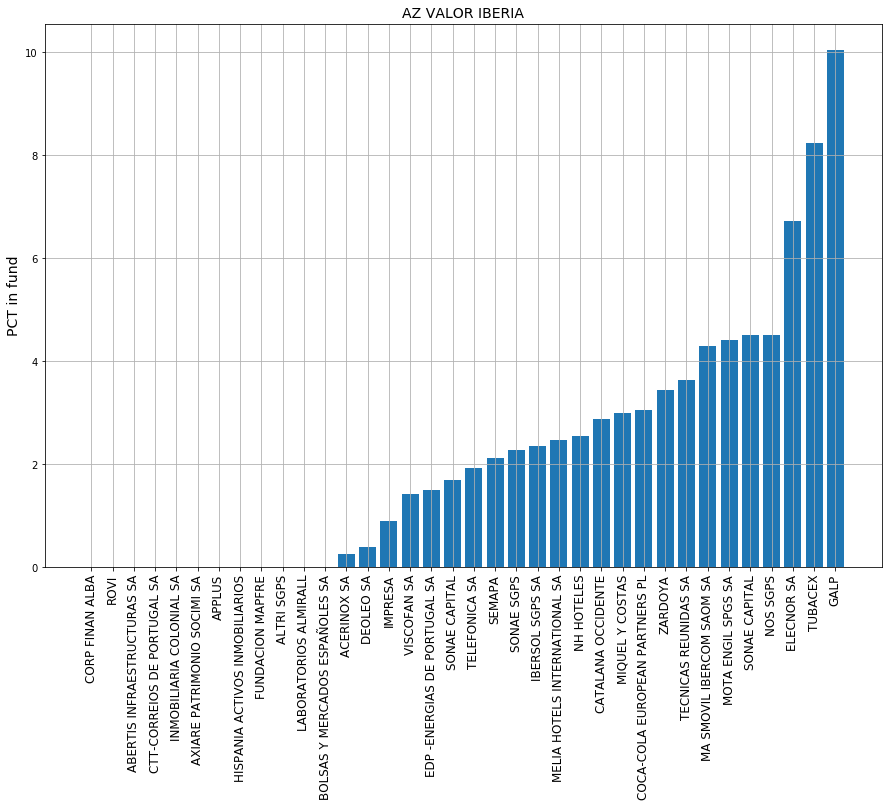

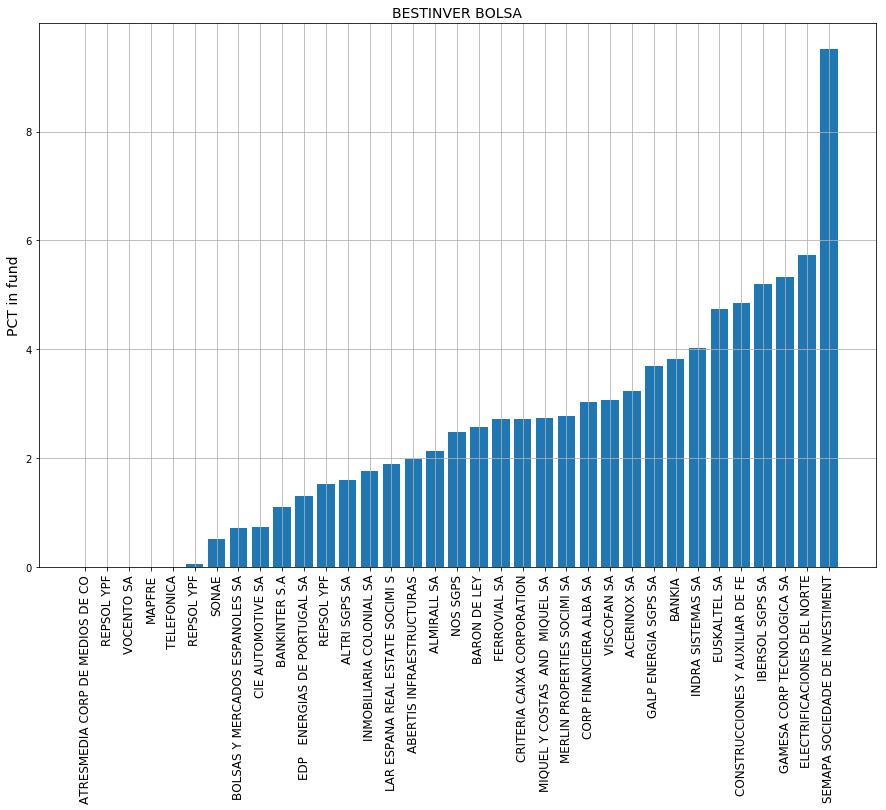

In [197]:
plot_fund_dist('COBAS IBERIA')
plot_fund_dist('AZ VALOR IBERIA')
plot_fund_dist('BESTINVER BOLSA')